# AR Forecaster

#### Imports

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold
import seaborn as sns

#### data setup

In [3]:
data_directory = '../data/experiment_small/'
data_true = np.load(data_directory + 'network_params/data_network.npy')
data_true = np.transpose(data_true, (1, 2, 0))
data_true.shape

(4, 2801, 2)

In [4]:
data_test = data_true[:,:100,:]

#### data processes

In [5]:
def time_slice_data(data, h, f):
    T = h + f
    samples = np.array([data[:,t:t + T,:] for t in range(len(data[0]) - T + 1)])
    return samples[:, :, :h, :], samples[:, : , h:, :]

In [6]:
hist_samples, future_samples = time_slice_data(data_test, 3, 1)

In [7]:
future_samples.shape

(97, 4, 1, 2)

In [8]:
hist_samples.shape

(97, 4, 3, 2)

#### AR forecaster

In [9]:
def fit_AR_forecaster(hist_samples, future_samples):
  
    m, N, h, _ = hist_samples.shape
    _, _, f, _ = future_samples.shape
    
    hist_sample_matrix = hist_samples.reshape(m * N, h * 2)
    future_sample_matrix = future_samples.reshape(m * N, f * 2)
    
    model = LinearRegression()
    model.fit(hist_sample_matrix, future_sample_matrix)

    return model

def get_AR_forecast(AR_model, history):
    N, h, _ = history.shape
    f = len(AR_model.intercept_)//2
    history = history.reshape(N, 2 * h)

    forecast = AR_model.predict(history)
    # return forecast
    return forecast.reshape(N,f,2)
    

#### validation and $h$ hyperparameter fitting

In [60]:
def get_mse(forecast, true_vals):
    # print(forecast.shape)
    N, f , _ = forecast.shape
    forecast = forecast.reshape(N, f * 2)
    true_vals = true_vals.reshape(N, f * 2)
    
    return mse(forecast, true_vals)

def K_fold(data, h=7, f=3, num_folds = 5):
    hist_samples, future_samples = time_slice_data(data, h, f)
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=0)
    return hist_samples, future_samples, kf.split(hist_samples)

def AR_crossval(hist_samples, future_samples, kf_split): 
    fold_mse_vals = []
    
    for train_index, test_index in kf_split:
        hist_train, hist_test = hist_samples[train_index], hist_samples[test_index]
        future_train, future_test = future_samples[train_index], future_samples[test_index]

        AR_model = fit_AR_forecaster(hist_train, future_train)
         
        forecast_test = np.array([get_AR_forecast(AR_model, hist) for hist in hist_test])
        mse_vals = np.array([get_mse(forecast_test[i], future_test[i]) for i in range(len(future_test))])
        fold_mse_vals +=[np.mean(mse_vals)]
    return np.mean(np.array(fold_mse_vals))

def AR_validation(data, h = 7, f = 3, num_folds = 5):
    hist_samples, future_samples, kf_split = K_fold(data, h=h, f=f, num_folds = num_folds)
    cv_mse = AR_crossval(hist_samples, future_samples, kf_split)
    return cv_mse

In [61]:
hist_samples, future_samples, kf_split = K_fold(data_true, h=20, f = 3, num_folds = 5)
cv_mse = AR_crossval(hist_samples, future_samples, kf_split)
cv_mse

19.661436376178283

In [32]:
h_max = 100
h_vals = np.arange(1,h_max+1)
mse_vals = []
for h in h_vals:
    mse_vals += [AR_validation(data_true, h = h, f = 3, num_folds = 5)]
    if h % 10 == 0:
        print (f'{h}/{h_max} done')
print('done!')

10/100 done
20/100 done
30/100 done
40/100 done
50/100 done
60/100 done
70/100 done
80/100 done
90/100 done
100/100 done
done!


Text(0.5, 1.0, 'h hyper param fitting via cross validation')

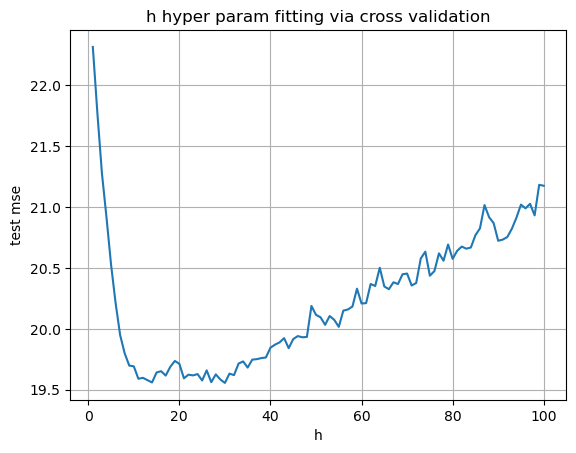

In [33]:
plt.plot(h_vals, mse_vals)
plt.grid()
plt.xlabel('h')
plt.ylabel('test mse')
plt.title('h hyper param fitting via cross validation')

In [30]:
f_max = 14
f_vals = np.arange(1,f_max)
mse_vals = []
for f in f_vals:
    mse_vals += [AR_validation(data_true, h = 20, f = f, num_folds =5)]
    if(f-1)% 5 == 0:
        print (f'{f}/{f_max} done')
print('done!')

1/14 done
6/14 done
11/14 done
done!


Text(0, 0.5, 'test mse')

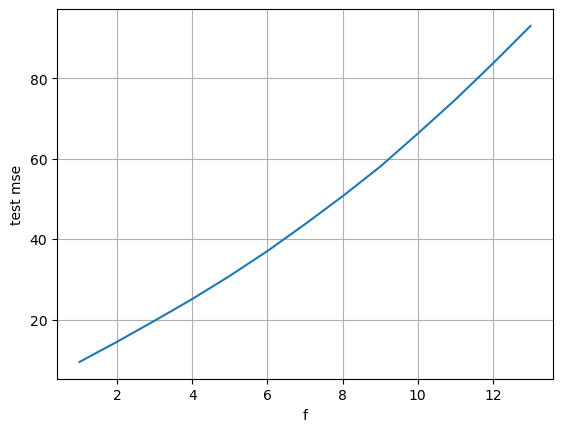

In [31]:
plt.plot(f_vals, mse_vals)
plt.grid()
plt.xlabel('f')
plt.ylabel('test mse')

In [65]:
h_vals = np.arange(1,60, 5)
f_vals = np.arange(1,8)

H, F = np.meshgrid(h_vals, f_vals)

cv_mse = np.zeros([len(h_vals), len(f_vals)])
for i in range(len(h_vals)): 
    for j in range(len(f_vals)): 
        cv_mse[i,j] = AR_validation(data_true, h_vals[i] , f_vals[j], num_folds = 2)
        

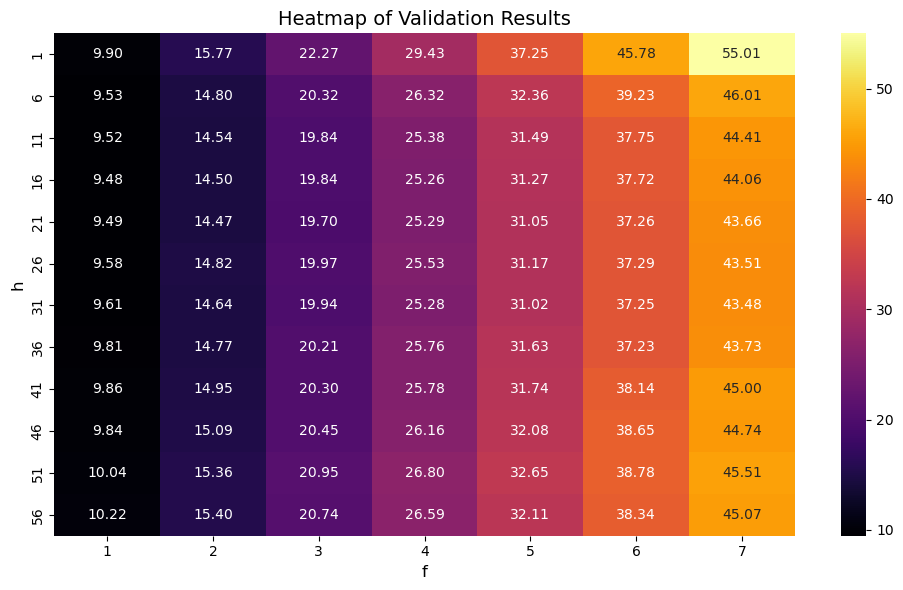

In [66]:
plt.figure(figsize=(10, 6))
sns.heatmap(cv_mse, annot=True, fmt=".2f", xticklabels=f_vals, yticklabels=h_vals, 
            cmap="inferno")

plt.xlabel('f', fontsize=12)
plt.ylabel('h', fontsize=12)
plt.title('Heatmap of Validation Results', fontsize=14)
plt.tight_layout()
plt.show()